In [1]:
import mlflow
import mlflow.keras as mlflowKeras
import mlflow.tensorflow
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec
from azureml.core import Workspace
from azureml.core.model import Model


import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from pyngrok import ngrok
from getpass import getpass

import joblib

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

from datetime import datetime
from dotenv import load_dotenv
import os

2024-12-06 19:42:02.696780: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 19:42:02.712703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 19:42:02.732034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 19:42:02.737587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 19:42:02.751448: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Levanto el servicio de MLFlow
get_ipython().system_raw("mlflow ui --port 5000 &")

# Termino los tuneles abiertos 
ngrok.kill()

[2024-12-06 16:42:03 +0000] [12014] [INFO] Starting gunicorn 22.0.0
[2024-12-06 16:42:03 +0000] [12014] [INFO] Listening at: http://127.0.0.1:5000 (12014)
[2024-12-06 16:42:03 +0000] [12014] [INFO] Using worker: sync
[2024-12-06 16:42:03 +0000] [12015] [INFO] Booting worker with pid: 12015
[2024-12-06 16:42:03 +0000] [12016] [INFO] Booting worker with pid: 12016
[2024-12-06 16:42:03 +0000] [12017] [INFO] Booting worker with pid: 12017
[2024-12-06 16:42:03 +0000] [12018] [INFO] Booting worker with pid: 12018


In [3]:
#Cargo las variables de entorno
load_dotenv()

# Accedo al token de autentificación para iniciar la aplicación en Ngrok
NGROK_AUTH_TOKEN = os.environ.get('NGROK_TOKEN')

ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://08b6-52-147-172-125.ngrok-free.app


In [4]:
#Establezco una semilla
np.random.seed(42)

In [5]:
#Cargo los datos
data_final = pd.read_csv('./uk_electricity.csv', parse_dates=["settlement_date"])

#Relleno de 0 los NaN
data_final.fillna(0, inplace=True)

#Cambio el tipo de dato para optimizar el espacio en memoria
def change_type():

  data_final["settlement_period"] = data_final["settlement_period"].astype(np.int8)
  data_final["period_hour"] = data_final["period_hour"].astype(np.float16)
  data_final["nd"] = data_final["nd"].astype(np.uint16)
  data_final["tsd"] = data_final["tsd"].astype(np.uint16)
  data_final["england_wales_demand"] = data_final["england_wales_demand"].astype(np.uint16)
  data_final['embedded_wind_generation'] = data_final['embedded_wind_generation'].astype(np.int16)
  data_final['embedded_solar_generation'] = data_final['embedded_solar_generation'].astype(np.int16)
  data_final["non_bm_stor"] = data_final["non_bm_stor"].astype(np.int16)
  data_final["pump_storage_pumping"] = data_final["pump_storage_pumping"].astype(np.int16)
  data_final["ifa_flow"] = data_final["ifa_flow"].astype(np.int16)
  data_final["ifa2_flow"] = data_final["ifa2_flow"].astype(np.int16)
  data_final["britned_flow"] = data_final["britned_flow"].astype(np.int16)
  data_final["moyle_flow"] = data_final["moyle_flow"].astype(np.int16)
  data_final["east_west_flow"] = data_final["east_west_flow"].astype(np.int16)
  data_final["nemo_flow"] = data_final["nemo_flow"].astype(np.int16)
  data_final['is_holiday'] = data_final['is_holiday'].astype(np.bool_)

change_type()

In [6]:
#Se hace un poco de Analisis Exploratorio
data_final.describe()

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_solar_generation,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow
count,277504.000000,277504.0,277504.000000,277504.000000,277504.000000,277504.000000,277504.000000,277504.000000,277504.000000,277504.000000,277504.000000,277504.000000,277504.000000,277504.000000,277504.000000
mean,24.497348,NaN,31186.527845,32683.966267,28387.983135,1267.343332,881.393681,6.692639,304.892906,926.214487,52.144009,504.640679,-124.718083,-50.375126,175.323833
std,13.852020,0.0,7835.788973,7603.465939,7095.347486,961.219826,1712.441492,39.266711,528.727730,1069.590624,352.259884,541.342987,230.117887,262.934922,421.206578
min,1.000000,0.0,13367.000000,16513.000000,0.000000,0.000000,0.000000,-24.000000,0.000000,-2056.000000,-1030.000000,-1215.000000,-505.000000,-585.000000,-1023.000000
25%,12.000000,5.5,24905.000000,26604.000000,22673.000000,551.000000,0.000000,0.000000,8.000000,270.000000,0.000000,0.000000,-302.000000,-207.000000,0.000000
50%,24.000000,11.5,30487.000000,31797.000000,27746.000000,1015.000000,0.000000,0.000000,11.000000,1187.000000,0.000000,727.000000,-148.000000,0.000000,0.000000
75%,36.000000,17.5,36913.000000,38110.000000,33614.250000,1722.000000,891.000000,0.000000,366.000000,1893.000000,0.000000,994.000000,26.000000,0.000000,325.000000
max,48.000000,23.5,59095.000000,60147.000000,53325.000000,5587.000000,11224.000000,893.000000,2019.000000,2066.000000,1016.000000,1143.000000,499.000000,504.000000,1033.000000


In [7]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277504 entries, 0 to 277503
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   settlement_date            277504 non-null  datetime64[ns]
 1   settlement_period          277504 non-null  int8          
 2   period_hour                277504 non-null  float16       
 3   nd                         277504 non-null  uint16        
 4   tsd                        277504 non-null  uint16        
 5   england_wales_demand       277504 non-null  uint16        
 6   embedded_wind_generation   277504 non-null  int16         
 7   embedded_solar_generation  277504 non-null  int16         
 8   non_bm_stor                277504 non-null  int16         
 9   pump_storage_pumping       277504 non-null  int16         
 10  ifa_flow                   277504 non-null  int16         
 11  ifa2_flow                  277504 non-null  int16   

In [8]:
data_final.head()

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_solar_generation,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
0,2009-01-01 00:00:00,1,0.0,37910,38704,33939,54,0,0,33,2002,0,0,-161,0,0,True
1,2009-01-01 00:30:00,2,0.5,38047,38964,34072,53,0,0,157,2002,0,0,-160,0,0,True
2,2009-01-01 01:00:00,3,1.0,37380,38651,33615,53,0,0,511,2002,0,0,-160,0,0,True
3,2009-01-01 01:30:00,4,1.5,36426,37775,32526,50,0,0,589,1772,0,0,-160,0,0,True
4,2009-01-01 02:00:00,5,2.0,35687,37298,31877,50,0,0,851,1753,0,0,-160,0,0,True


In [18]:
pd.options.display.max_rows=20
data_final.corr()

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_solar_generation,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
settlement_period,1.000000,1.000000,0.420161,0.389427,0.422950,0.039675,0.067650,0.043741,-0.608511,0.090823,0.041818,0.116404,-0.200944,-0.179955,0.078651,0.000029
period_hour,1.000000,1.000000,0.420161,0.389427,0.422950,0.039675,0.067650,0.043741,-0.608511,0.090823,0.041818,0.116404,-0.200944,-0.179955,0.078651,0.000029
nd,0.420161,0.420161,1.000000,0.992050,0.998343,-0.157873,-0.155251,0.147904,-0.457666,-0.061599,-0.051882,0.095264,-0.276897,-0.165453,-0.106178,-0.066291
tsd,0.389427,0.389427,0.992050,1.000000,0.990968,-0.150501,-0.172877,0.136094,-0.411760,-0.137031,-0.102040,0.041005,-0.286561,-0.173889,-0.153518,-0.068704
england_wales_demand,0.422950,0.422950,0.998343,0.990968,1.000000,-0.130721,-0.161598,0.143656,-0.462071,-0.066238,-0.054399,0.093098,-0.268078,-0.159897,-0.105661,-0.071664
embedded_wind_generation,0.039675,0.039675,-0.157873,-0.150501,-0.130721,1.000000,0.164751,-0.015292,-0.068593,-0.074205,-0.018115,-0.009618,0.203343,0.166842,0.162825,-0.010704
embedded_solar_generation,0.067650,0.067650,-0.155251,-0.172877,-0.161598,0.164751,1.000000,0.003801,-0.259079,0.088117,0.118861,0.154085,-0.103097,-0.208123,0.239189,0.000132
non_bm_stor,0.043741,0.043741,0.147904,0.136094,0.143656,-0.015292,0.003801,1.000000,-0.093262,0.052618,-0.025007,0.076544,-0.011524,-0.035219,-0.057513,-0.008328
pump_storage_pumping,-0.608511,-0.608511,-0.457666,-0.411760,-0.462071,-0.068593,-0.259079,-0.093262,1.000000,-0.031566,-0.075665,-0.025654,0.209506,0.212732,-0.131457,-0.002300
ifa_flow,0.090823,0.090823,-0.061599,-0.137031,-0.066238,-0.074205,0.088117,0.052618,-0.031566,1.000000,0.286530,0.380132,-0.040608,-0.184594,0.220917,0.024376


In [9]:
data_final.isna().sum()

settlement_date              0
settlement_period            0
period_hour                  0
nd                           0
tsd                          0
england_wales_demand         0
embedded_wind_generation     0
embedded_solar_generation    0
non_bm_stor                  0
pump_storage_pumping         0
ifa_flow                     0
ifa2_flow                    0
britned_flow                 0
moyle_flow                   0
east_west_flow               0
nemo_flow                    0
is_holiday                   0
dtype: int64

In [10]:
data_final = data_final.set_index('settlement_date')
data_final = data_final.sort_index()
data_final.head()

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_solar_generation,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
settlement_date,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,1,0.0,37910,38704,33939,54,0,0,33,2002,0,0,-161,0,0,True
2009-01-01 00:30:00,2,0.5,38047,38964,34072,53,0,0,157,2002,0,0,-160,0,0,True
2009-01-01 01:00:00,3,1.0,37380,38651,33615,53,0,0,511,2002,0,0,-160,0,0,True
2009-01-01 01:30:00,4,1.5,36426,37775,32526,50,0,0,589,1772,0,0,-160,0,0,True
2009-01-01 02:00:00,5,2.0,35687,37298,31877,50,0,0,851,1753,0,0,-160,0,0,True


In [11]:
# Asegurandose de que los datos estén ordenados por fecha
data = data_final.drop(["embedded_solar_generation","embedded_wind_generation","ifa_flow","ifa2_flow","pump_storage_pumping" ,"britned_flow", "nemo_flow", "is_holiday","moyle_flow", "east_west_flow"], axis=1)
data = data.sort_index()

# Se seleccionan la variable objetivo y las características
target_column = 'nd'  # Variable objetivo
features = data.columns.tolist()

# Escalado de los datos
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


# Creación de ventanas de tiempo (secuencias)
def create_sequences(data, target_index, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, target_index])
    return np.array(X), np.array(y)

# Parámetros de la ventana de tiempo
window_size = 48  # Predicciones basadas en las últimas 48 horas (dos días)
target_index = features.index(target_column)  # Índice de la variable objetivo

# Crear conjuntos de datos para entrenamiento y prueba
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

X_train, y_train = create_sequences(train_data, target_index, window_size)
X_test, y_test = create_sequences(test_data, target_index, window_size)

In [12]:
#Guardo el Scaler
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [13]:
#Configuro el Experimento en MLFLow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("mlflow-tensorflow-uk-energy")

<Experiment: artifact_location='mlflow-artifacts:/177021876993424057', creation_time=1733479229894, experiment_id='177021876993424057', last_update_time=1733479229894, lifecycle_stage='active', name='mlflow-tensorflow-uk-energy', tags={}>

In [15]:
# Configuro el nombre único del run
name = "tensorflow_series_UK_energy" + datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

# Inicio del experimento en MLFlow
with mlflow.start_run(run_name=name) as run:
    
    # Registro hiperparámetros
    mlflow.log_param("model_type", "LSTM")
    mlflow.log_param("units", 50)
    mlflow.log_param("activation", "relu")
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss", "mae")
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 25)

    # Definir y entrenar la RNN
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mae', metrics=["accuracy", "mse"])

    # Early stopping para evitar sobreajuste
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entrenamiento del modelo
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=25,
        batch_size=32,
        callbacks=[early_stopping,mlflowKeras.MlflowCallback()],
       verbose=1
    )

    # Registra métricas (últimos valores)
    mlflow.log_metric("final_loss", history.history['loss'][-1])
    mlflow.log_metric("final_val_loss", history.history['val_loss'][-1])
    mlflow.log_metric("final_accuracy", history.history['accuracy'][-1])
    mlflow.log_metric("final_val_accuracy", history.history['val_accuracy'][-1])

    # Definir las columnas de entrada para la predicción
    input_schema = Schema([
        TensorSpec(np.dtype(np.int16),(-1,), name="settlement_period"),  # int8 → integer
        TensorSpec(np.dtype(np.float16),(-1,), name="period_hour"),         # float16 → float
        TensorSpec(np.dtype(np.uint16),(-1,), name="tsd"),               # uint16 → integer
        TensorSpec(np.dtype(np.int16),(-1,), name="england_wales_demand"),  # uint16 → integer
        TensorSpec(np.dtype(np.int16),(-1,), name="non_bm_stor"),       # int16 → integer
    ])

    # Definir las columnas de salida
    output_schema = Schema([
        TensorSpec(np.dtype(np.float32), (-1,), name="nd")
    ])

    # Crear la firma del modelo
    signature = ModelSignature(inputs=input_schema, outputs=output_schema)

    # Grafico las métricas de pérdida
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.title("Training and Validation Loss")
    plt.savefig("training_validation_loss.png")
    plt.close()

    # Registrando el gráfico de perdida como un artefacto
    mlflow.log_artifact("training_validation_loss.png")
    mlflow.log_artifact("scaler.pkl")

🏃 View run tensorflow_series_UK_energy2024-12-06_17:09:49 at: http://127.0.0.1:5000/#/experiments/177021876993424057/runs/f894768384354413944cec0aceeaf022
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/177021876993424057


1733/1733 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
RMSE: 6.44 MW
MAE: 4.99 MW
R²: 1.00


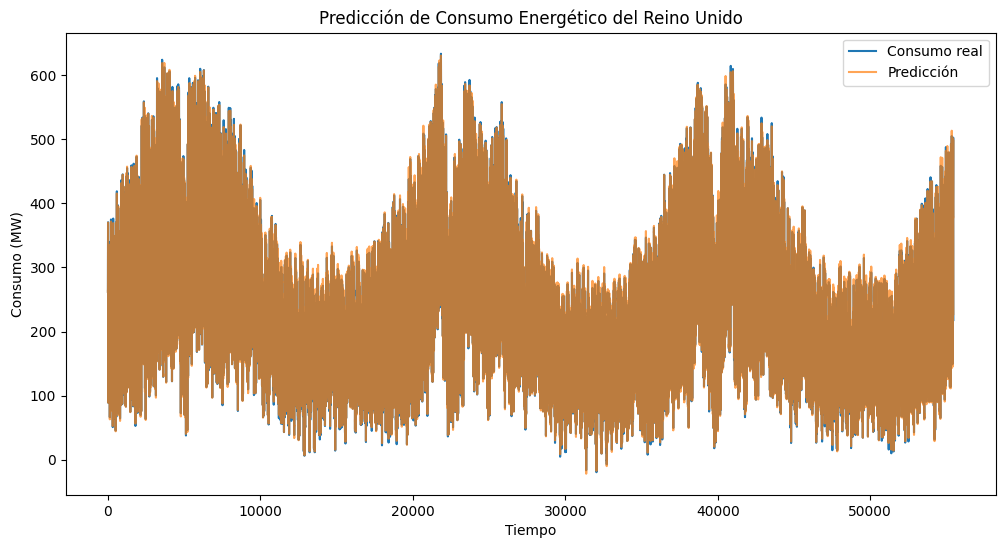

In [16]:
#Evaluación del modelo
# Predecir valores
y_pred = model.predict(X_test)

# Invertir la escala de los datos para interpretar los resultados
y_test_original = scaler.inverse_transform(np.hstack([np.zeros((len(y_test), data.shape[1] - 1)), y_test.reshape(-1, 1)]))[:, -1]
y_pred_original = scaler.inverse_transform(np.hstack([np.zeros((len(y_pred), data.shape[1] - 1)), y_pred]))[:, -1]

# Métricas de evaluación
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"RMSE: {rmse:.2f} MW")
print(f"MAE: {mae:.2f} MW")
print(f"R²: {r2:.2f}")

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Consumo real')
plt.plot(y_pred_original, label='Predicción', alpha=0.7)
plt.legend()
plt.title('Predicción de Consumo Energético del Reino Unido')
plt.xlabel('Tiempo')
plt.ylabel('Consumo (MW)')
plt.show()

In [31]:
!conda env export > environment.yml

In [17]:
!pip freeze > "./requirements.txt"

In [19]:
env = {
  "name": "uk-energy-enviroment",
  "channels": [
    "conda-forge",
    "defaults"
  ],
  "dependencies": [
    "conda-forge::ncurses",
    "_libgcc_mutex=0.1=conda_forge",
    "_openmp_mutex=4.5=2_gnu",
    "anaconda-anon-usage=0.4.4=py312hfc0e8ea_100",
    "archspec=0.2.3=pyhd3eb1b0_0",
    "boltons=23.0.0=py312h06a4308_0",
    "brotli-python=1.0.9=py312h6a678d5_8",
    "bzip2=1.0.8=h5eee18b_6",
    "c-ares=1.19.1=h5eee18b_0",
    "ca-certificates=2024.8.30=hbcca054_0",
    "certifi=2024.8.30=pyhd8ed1ab_0",
    "cffi=1.16.0=py312h5eee18b_1",
    "charset-normalizer=3.3.2=pyhd3eb1b0_0",
    "conda=24.7.1=py312h7900ff3_0",
    "conda-content-trust=0.2.0=py312h06a4308_1",
    "conda-libmamba-solver=24.7.0=pyhd3eb1b0_0",
    "conda-package-handling=2.3.0=py312h06a4308_0",
    "conda-package-streaming=0.10.0=py312h06a4308_0",
    "cryptography=42.0.5=py312hdda0065_1",
    "distro=1.9.0=py312h06a4308_0",
    "expat=2.6.2=h6a678d5_0",
    "fmt=9.1.0=hdb19cb5_1",
    "frozendict=2.4.2=py312h06a4308_0",
    "icu=73.1=h6a678d5_0",
    "idna=3.7=py312h06a4308_0",
    "jsonpatch=1.33=py312h06a4308_1",
    "jsonpointer=2.1=pyhd3eb1b0_0",
    "krb5=1.20.1=h143b758_1",
    "ld_impl_linux-64=2.38=h1181459_1",
    "libarchive=3.6.2=hfab0078_4",
    "libcurl=8.7.1=h251f7ec_0",
    "libedit=3.1.20230828=h5eee18b_0",
    "libev=4.33=h7f8727e_1",
    "libexpat=2.6.2=h59595ed_0",
    "libffi=3.4.4=h6a678d5_1",
    "libgcc=14.1.0=h77fa898_1",
    "libgcc-ng=14.1.0=h69a702a_1",
    "libgomp=14.1.0=h77fa898_1",
    "libmamba=1.5.8=hfe524e5_2",
    "libmambapy=1.5.8=py312h2dafd23_2",
    "libnghttp2=1.57.0=h2d74bed_0",
    "libnsl=2.0.1=hd590300_0",
    "libsolv=0.7.24=he621ea3_1",
    "libsqlite=3.46.0=hde9e2c9_0",
    "libssh2=1.11.0=h251f7ec_0",
    "libstdcxx-ng=11.2.0=h1234567_1",
    "libuuid=2.38.1=h0b41bf4_0",
    "libxcrypt=4.4.36=hd590300_1",
    "libxml2=2.13.1=hfdd30dd_2",
    "libzlib=1.2.13=h4ab18f5_6",
    "lz4-c=1.9.4=h6a678d5_1",
    "menuinst=2.1.2=py312h06a4308_0",
    "ncurses=6.4=h6a678d5_0",
    "openssl=3.3.2=hb9d3cd8_0",
    "packaging=24.1=py312h06a4308_0",
    "pcre2=10.42=hebb0a14_1",
    "pip=24.2=pyh8b19718_1",
    "platformdirs=3.10.0=py312h06a4308_0",
    "pluggy=1.0.0=py312h06a4308_1",
    "pybind11-abi=5=hd3eb1b0_0",
    "pycosat=0.6.6=py312h5eee18b_1",
    "pycparser=2.21=pyhd3eb1b0_0",
    "pysocks=1.7.1=py312h06a4308_0",
    "python=3.12.2=hab00c5b_0_cpython",
    "python_abi=3.12=5_cp312",
    "readline=8.2=h5eee18b_0",
    "reproc=14.2.4=h6a678d5_2",
    "reproc-cpp=14.2.4=h6a678d5_2",
    "requests=2.32.3=py312h06a4308_0",
    "ruamel.yaml=0.17.21=py312h5eee18b_0",
    "setuptools=72.1.0=py312h06a4308_0",
    "sqlite=3.45.3=h5eee18b_0",
    "tk=8.6.14=h39e8969_0",
    "tqdm=4.66.4=py312he106c6f_0",
    "truststore=0.8.0=py312h06a4308_0",
    "tzdata=2024a=h04d1e81_0",
    "urllib3=2.2.2=py312h06a4308_0",
    "wheel=0.43.0=py312h06a4308_0",
    "xz=5.4.6=h5eee18b_1",
    "yaml-cpp=0.8.0=h6a678d5_1",
    "zlib=1.2.13=h4ab18f5_6",
    "zstandard=0.22.0=py312h2c38b39_0",
    "zstd=1.5.5=hc292b87_2",
    {
      "pip": [
        "applicationinsights==0.11.10",
        "psutil==6.0.0",
        "azureml-inference-server-http==1.3.4"
      ]
    }
  ],
  "prefix": "/anaconda"
}

In [2]:
#Guardando el modelo
model_path = "./models/tensorflow_series_UK_energy_v2"
mlflow.keras.save_model(model, model_path,signature=signature, conda_env=env, pip_requirements="./requirements.txt")

In [3]:
# Cargo el workspace configurado
workspace = Workspace.from_config()

# Registro el modelo en el workspace
registered_model = Model.register(
    workspace=workspace,
    model_name="tensorflow_series_UK_energy",
    model_path=model_path,  # Ruta local donde se guardó el modelo
    description="Modelo LSTM para la prediccion de Energia en UK"
)

print(f"Modelo registrado con ID: {registered_model.id}")

Registering model tensorflow_series_UK_energy
Modelo registrado con ID: tensorflow_series_UK_energy:7


In [21]:
ngrok.kill()